# **Project 3**, APS1070 Fall 2023
#### **PCA [11 marks]**
**Deadline: Nov 17th, 23:00**



In this project we work on a [temperature dataset](https://berkeleyearth.org/data/) that reports the average earth surface temperature for different cities for each month over the years 1992-2006.

# Part 2: Applying PCA [2 Marks]

1. Compute the covariance matrix of the dataframe. *Hint: The dimensions of your covariance matrix should be (180, 180).* **[0.25]**
2. Write a function `get_sorted_eigen(df_cov)` that gets the covariance matrix of dataframe `df` (from step 1), and returns sorted eigenvalues and eigenvectors using `np.linalg.eigh`. **[0.25]**
3. Show the effectiveness of your principal components in covering the variance of the dataset with a `scree plot`. **[0.25]**
4. How many PCs do you need to cover 99% of the dataset's variance? **[0.25]**
5. Plot the first 16 principal components (Eigenvectors) as a time series (16 subplots, on the x-axis you have dates and on the y-axis you have the value of the PC element) . **[0.5]**
6. Compare the first two PCs with the rest of them. Do you see any difference in their trend? **[0.5]**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_raw = pd.read_csv(
    filepath_or_buffer='/content/TemperaturesbyCity.csv',
    index_col=0, header=0
)

In [2]:
#Q1
cov_matrix = data_raw.cov()
cov_matrix_shape = cov_matrix.shape
cov_matrix_shape

(180, 180)

In [3]:
#Q2
def get_sorted_eigen(df_cov):

    eigenvalues, eigenvectors = np.linalg.eigh(df_cov)

    idx = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[idx]
    sorted_eigenvectors = eigenvectors[:, idx]

    return sorted_eigenvalues, sorted_eigenvectors

eigenvalues, eigenvectors = get_sorted_eigen(cov_matrix)
eigenvalues[:5]

array([12223.71772249,  1569.35813811,   147.20871785,    42.0375833 ,
          26.90087954])

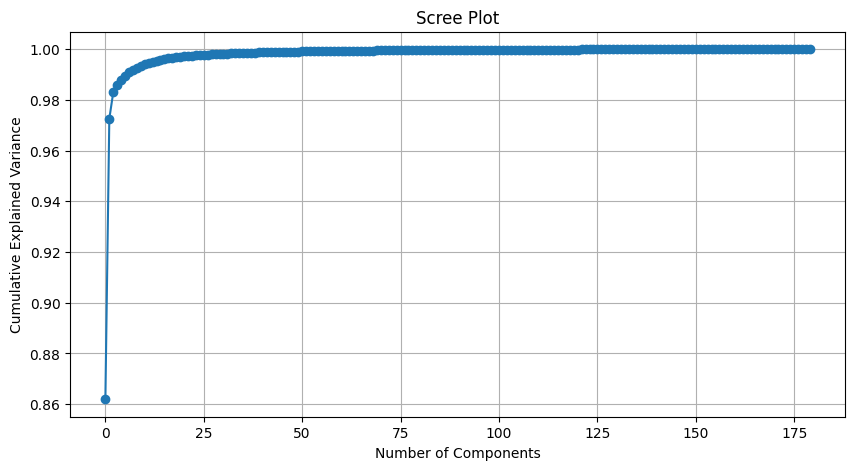

In [ ]:
#Q3
def plot_scree(eigenvalues):
    var_explained = eigenvalues / eigenvalues.sum()

    plt.figure(figsize=(10, 5))
    plt.plot(np.cumsum(var_explained), marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Scree Plot')
    plt.grid(True)

    return var_explained

variance_explained = plot_scree(eigenvalues)
plt.show()

In [ ]:
#Q4
cumulative_variance = np.cumsum(variance_explained)
num_components_for_99_variance = np.where(cumulative_variance >= 0.99)[0][0] + 1
num_components_for_99_variance

7

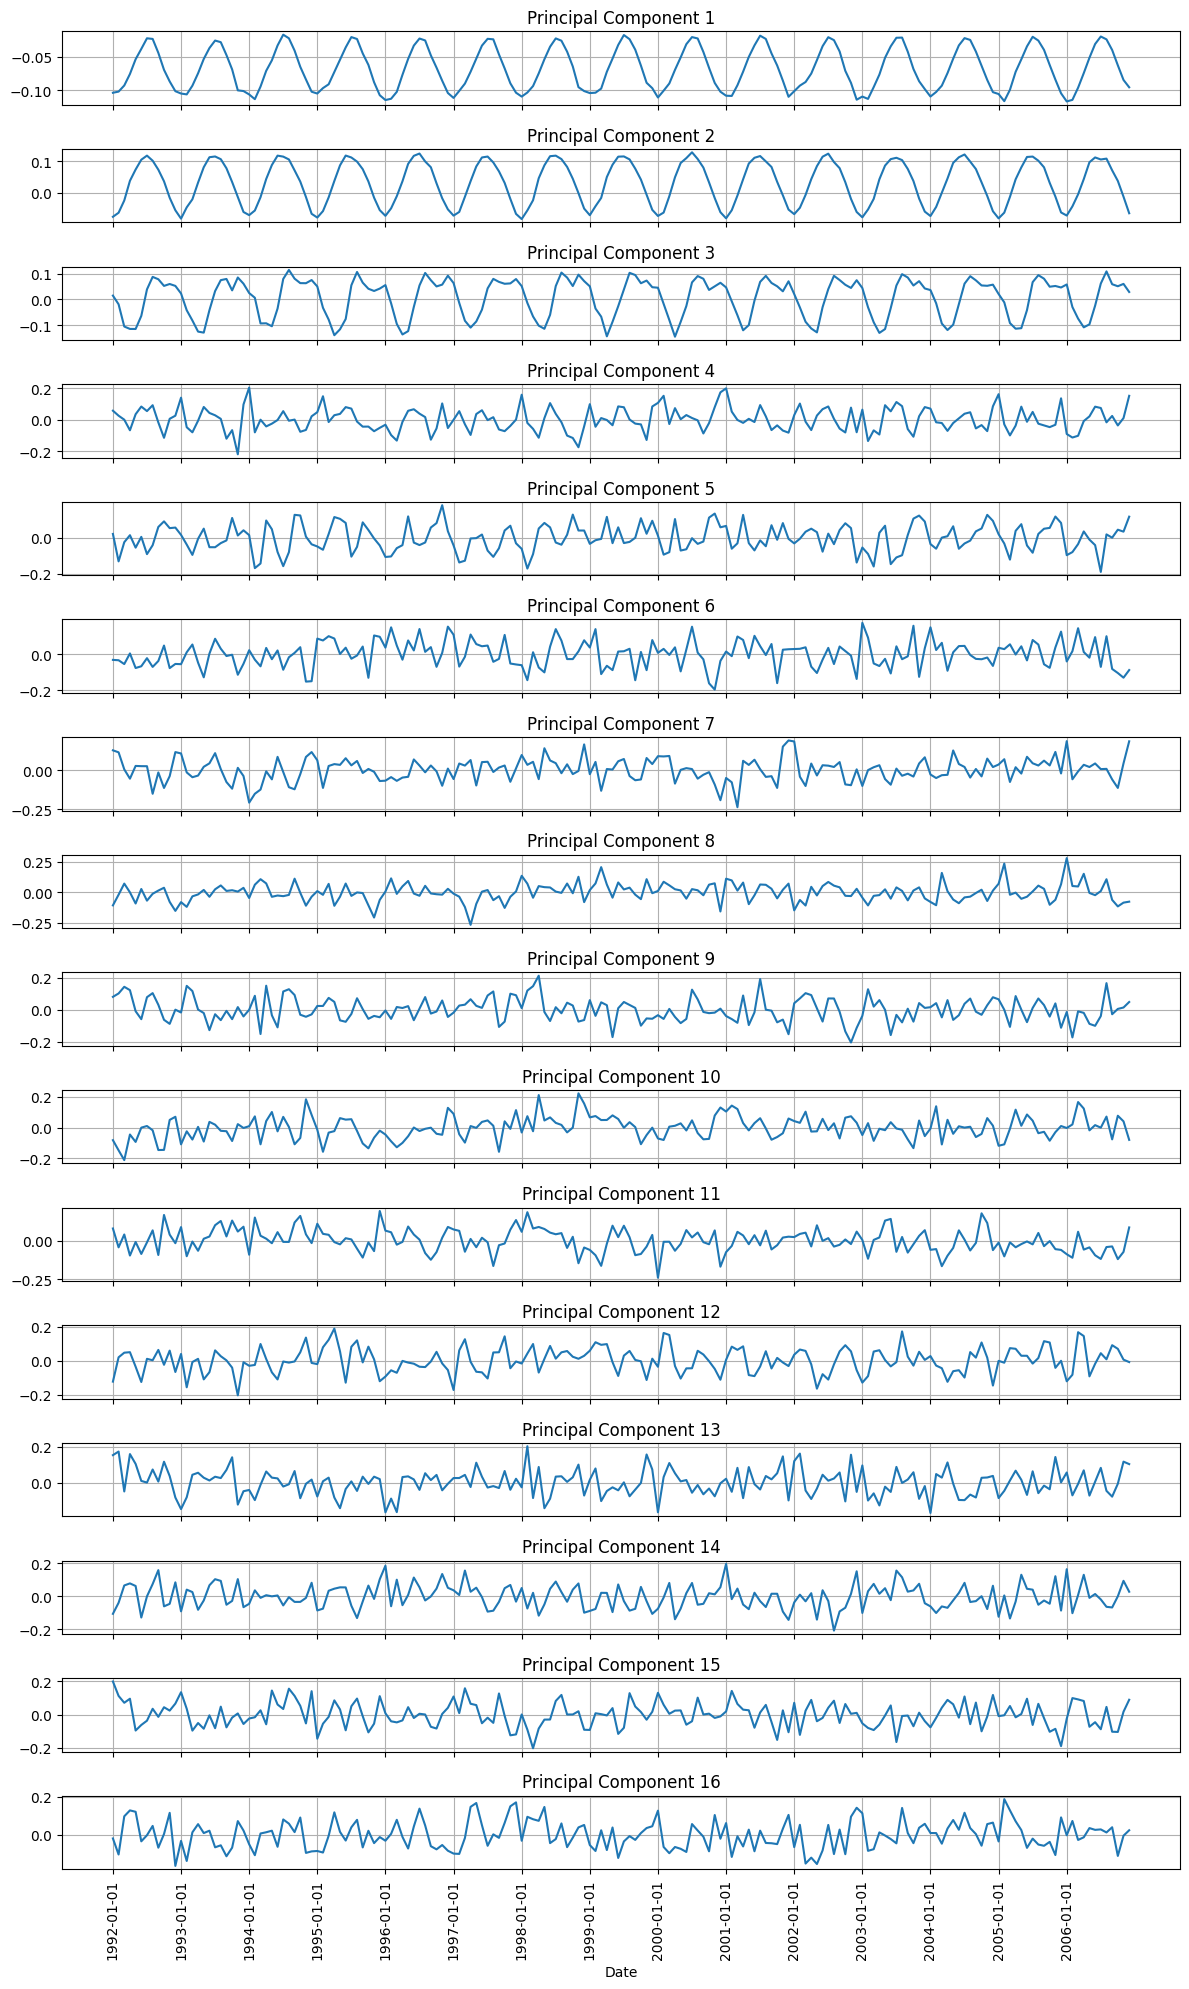

In [12]:
#Q5
def plot_principal_components(eigenvectors, num_components):

    dates = data_raw.columns

    # Determine indices for the start of each year in the date labels
    year_starts = [i for i in range(len(dates)) if dates[i].endswith('-01-01')]

    fig, axes = plt.subplots(num_components, 1, figsize=(12, 20), sharex=True)

    for i in range(num_components):
        ax = axes[i]
        ax.plot(dates, eigenvectors[:, i], label=f'PC{i+1}')
        ax.set_title(f'Principal Component {i+1}')
        ax.grid(True)

    # Set x-ticks only at the start of each year and rotate labels for better readability
    plt.xticks(ticks=dates[year_starts], labels=dates[year_starts], rotation=90)

    plt.xlabel('Date')
    plt.tight_layout()
    plt.show()

plot_principal_components(eigenvectors, 16)

The first two PCs contains the most variances, and their patterns turn out to be cyclical and orthogonal to each other. The rest of the principal components capture progressively less variance and are often used to identify more nuanced patterns in the data.

# Part 3: Data reconstruction [3 Marks]

Create a function that:

*   Accepts a city and the original dataset as inputs.
*   Calls useful functions that you designed in previous parts to compute eigenvectors and eigenvalues.
*   Plots 4 figures:
  1.   The original time-series for the specified city. **[0.5]**
  2.   The incremental reconstruction of the **original** (not standardized) time-series for the specified city in a single plot. **[1.5]**
       * You should at least show 5 curves in a figure for incremental reconstruction. For example, you can pick the following (or any other combination that you think is reasonable):
          * Reconstruction with only PC1
          * Reconstruction with both PC1 and PC2
          * Reconstruction with PC1 to PC4 (First 4 PCs)
          * Reconstruction with PC1 to PC8 (First 8 PCs)
          * Reconstruction with PC1 to PC16 (First 16 PCs)

      * Hint: you need to compute the reconstruction for the standardized time-series first, and then scale it back to the original (non-standardized form) using the StandardScaler `inverse_transform` [help...](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.inverse_transform)
  3.   The residual error for your best reconstruction with respect to the original time-series. **[0.5]**
      * Hint: You are plotting the error that we have for reconstructing each month `(df - df_reconstructed)`. On the x-axis, you have dates, and on the y-axis, the residual error.
  4.   The RMSE of the reconstruction as a function of the number of included components (x-axis is the number of components and y-axis is the RMSE). Sweep x-axis from 1 to 10 (this part is independent from part 3.2.) **[1]**

Test your function using the `Yakeshi`, `Zamboanga`, `Norilsk`, `Juliaca`, and `Doha` as inputs. **[0.5]**


City: Yakeshi


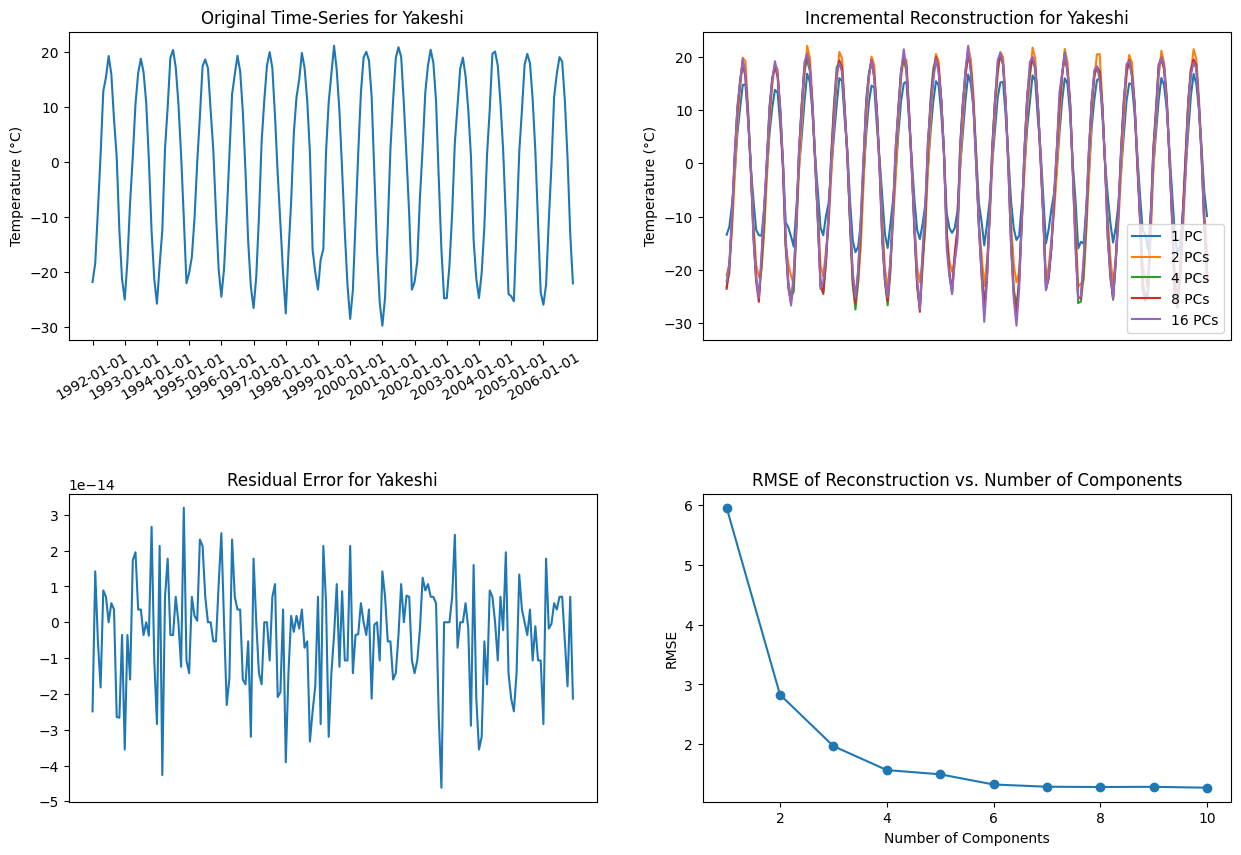

City: Zamboanga


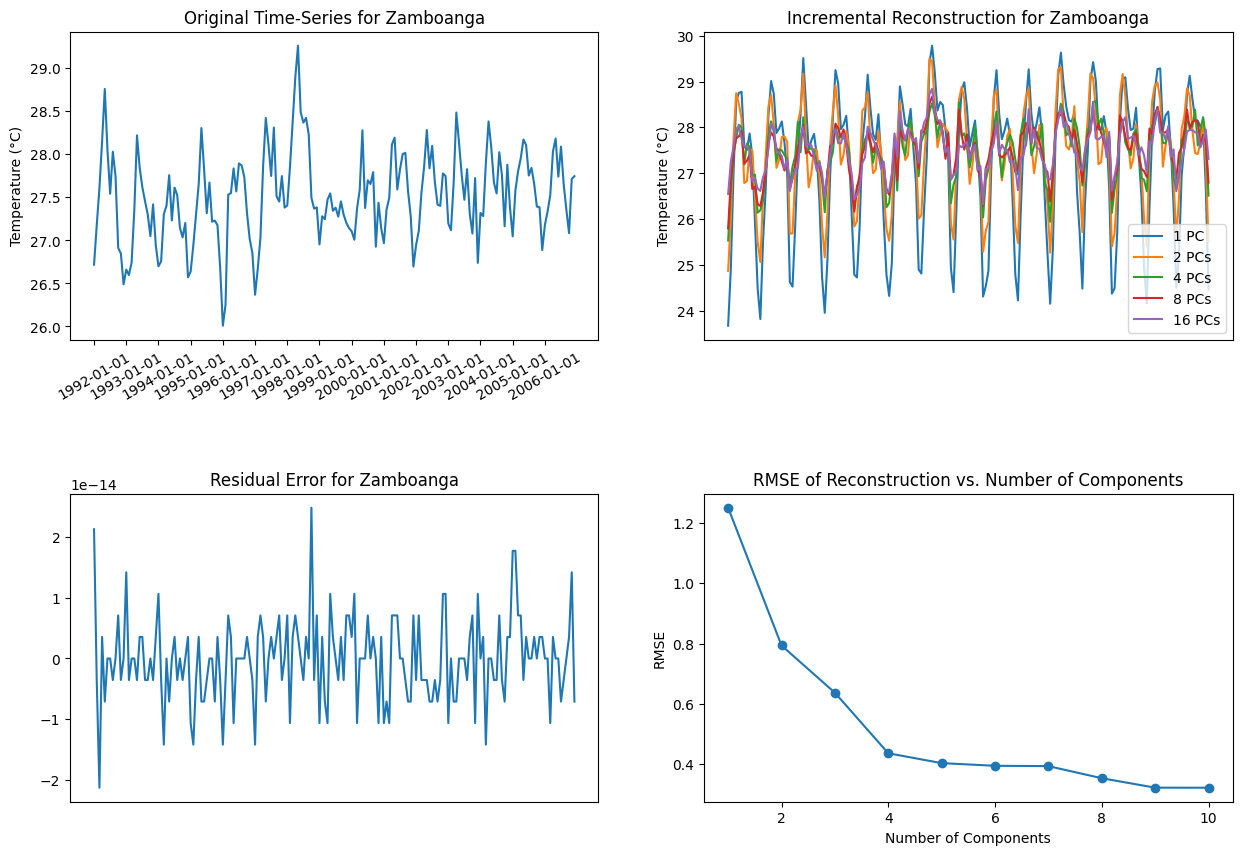

City: Norilsk


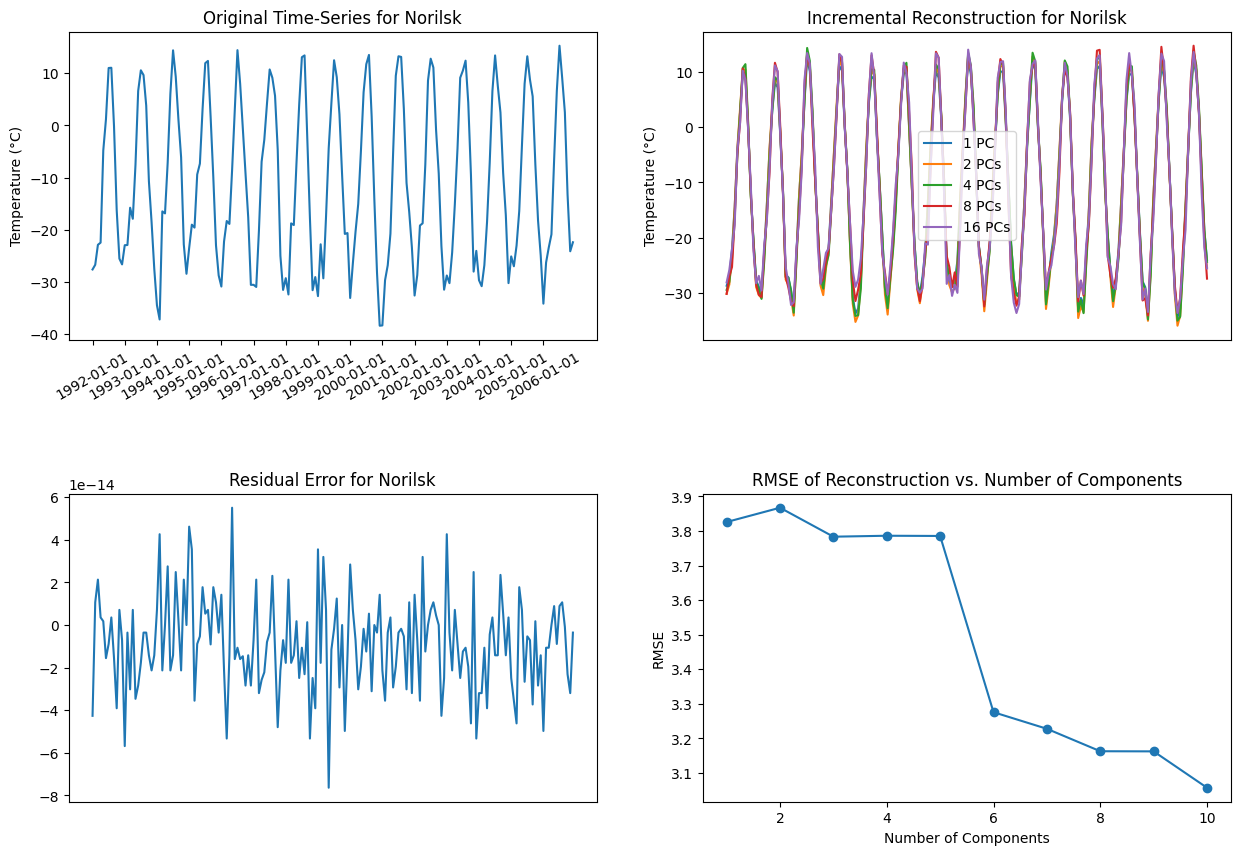

City: Juliaca


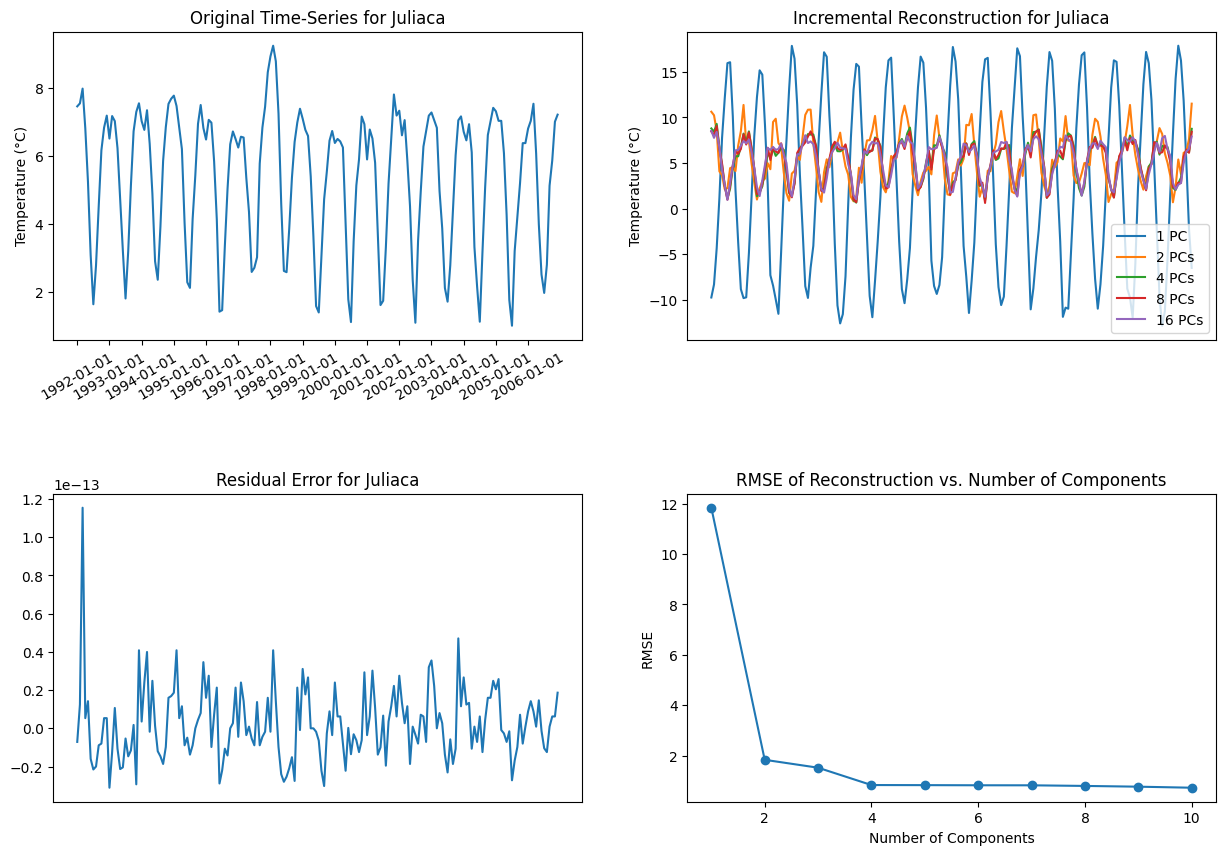

City: Doha


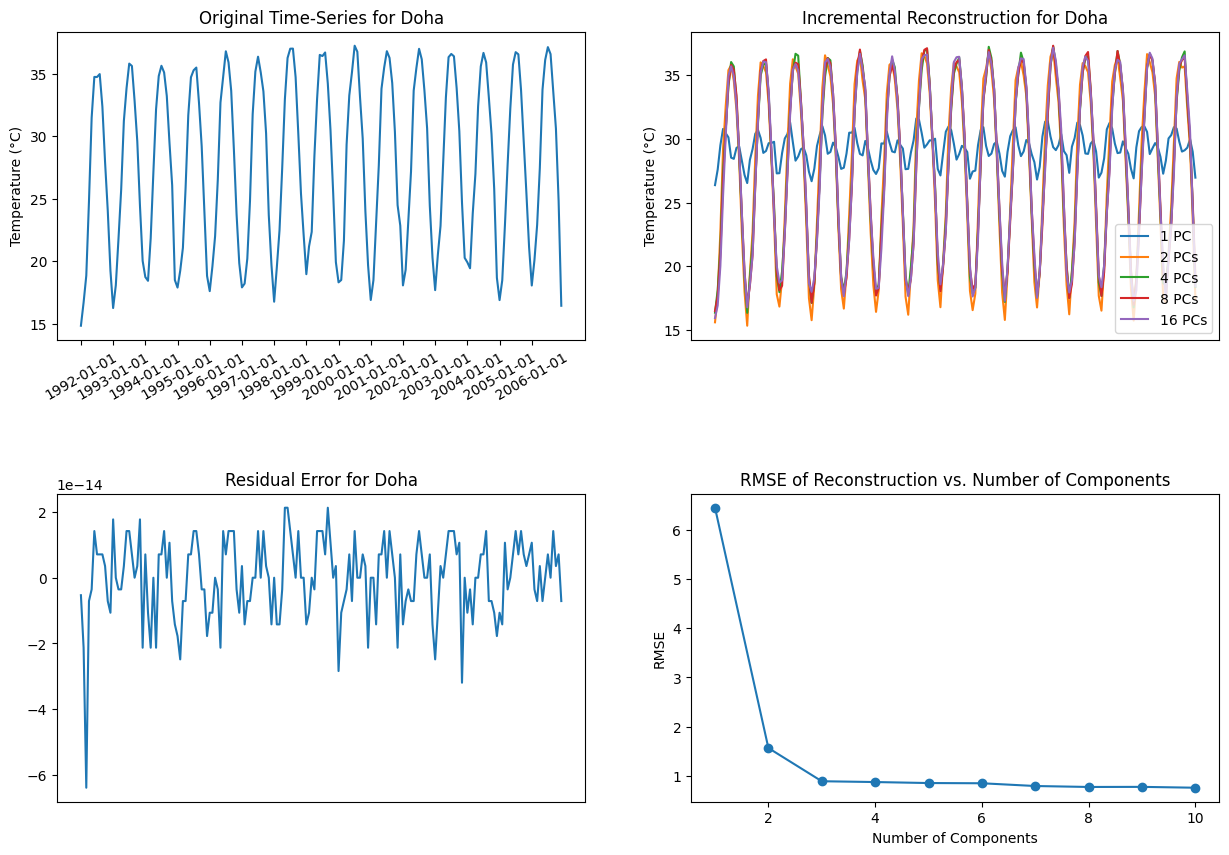

In [15]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

def plot_city_figures(original_df, city_name):

    scaler = StandardScaler()
    df_standardized = scaler.fit_transform(original_df)

    cov_matrix_standardized = np.cov(df_standardized, rowvar=False)
    eigenvalues_standardized, eigenvectors_standardized = get_sorted_eigen(cov_matrix_standardized)

    original_time_series = original_df.loc[city_name].values
    original_time_series_standardized = scaler.transform(original_time_series.reshape(1, -1))

    scores = np.dot(original_time_series_standardized, eigenvectors_standardized)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    plt.subplots_adjust(hspace=0.5, wspace=0.2)

    dates = original_df.columns
    year_starts = [i for i in range(len(dates)) if dates[i].endswith('-01-01')]

    # Plot 1: Original time-series
    axes[0, 0].plot(dates, original_time_series)
    axes[0, 0].set_title(f'Original Time-Series for {city_name}')
    axes[0, 0].set_ylabel('Temperature (°C)')
    axes[0, 0].set_xticks(ticks=dates[year_starts], labels=dates[year_starts], rotation=30)

    # Plot 2: Incremental reconstruction
    pcs_to_include = [1, 2, 4, 8, 16]
    for i in pcs_to_include:
        reconstructed_standardized = np.dot(scores[:, :i], eigenvectors_standardized[:, :i].T)
        reconstructed = scaler.inverse_transform(reconstructed_standardized)
        axes[0, 1].plot(original_df.columns, reconstructed.flatten(),
                         label=f'{i} PCs' if i > 1 else f'{i} PC')
    axes[0, 1].set_title(f'Incremental Reconstruction for {city_name}')
    axes[0, 1].set_ylabel('Temperature (°C)')
    axes[0, 1].set_xticks([])
    axes[0, 1].legend()

    # Plot 3: Residual error for the best reconstruction
    best_reconstructed_standardized = np.dot(scores, eigenvectors_standardized.T)
    best_reconstructed = scaler.inverse_transform(best_reconstructed_standardized)
    residual_error = original_time_series - best_reconstructed.flatten()
    axes[1, 0].plot(original_df.columns, residual_error)
    axes[1, 0].set_title(f'Residual Error for {city_name}')
    axes[1, 0].set_xticks([])


    # Plot 4: RMSE as a function of the number of components
    rmse_values = []
    num_components_range = range(1, 11)
    for i in num_components_range:
        reconstructed_standardized = np.dot(scores[:, :i], eigenvectors_standardized[:, :i].T)
        reconstructed = scaler.inverse_transform(reconstructed_standardized)
        rmse = np.sqrt(np.mean((original_time_series - reconstructed.flatten())**2))
        rmse_values.append(rmse)
    axes[1, 1].plot(num_components_range, rmse_values, marker='o')
    axes[1, 1].set_title('RMSE of Reconstruction vs. Number of Components')
    axes[1, 1].set_xlabel('Number of Components')
    axes[1, 1].set_ylabel('RMSE')

    plt.show()


cities = ['Yakeshi','Zamboanga', 'Norilsk', 'Juliaca', 'Doha']

for city in cities:
    print(f"City: {city}")
    rmse_values = plot_city_figures(data_raw, city)

# Part 4: SVD [2 Marks]
Modify your code in part 3 to use SVD instead of PCA for extracting the eigenvectors. **[1]**

Explain if standardization or covariance computation is required for this part.
Repeat part 3 and compare your PCA and SVD results. Write a function to make this comparison **[0.5]**, and comment on the results. **[0.5]**.

City: Yakeshi


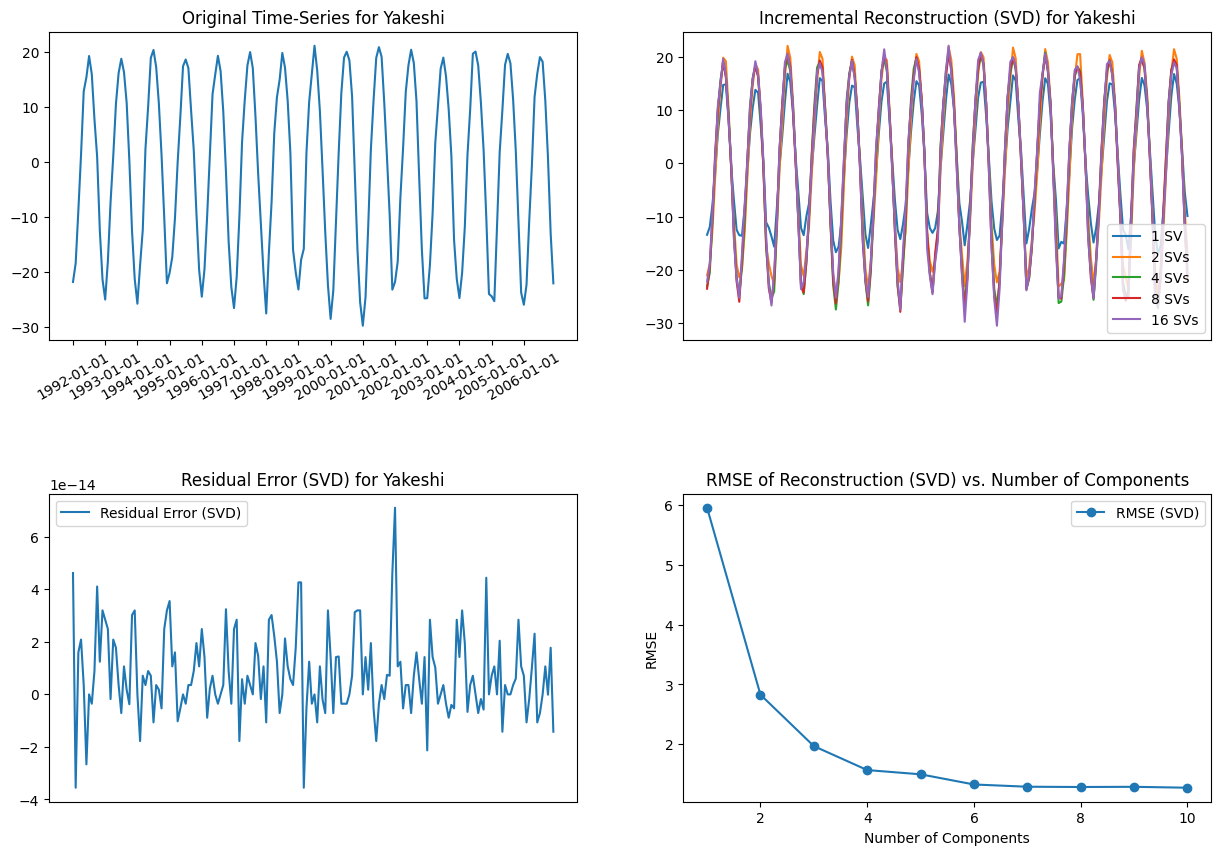

City: Zamboanga


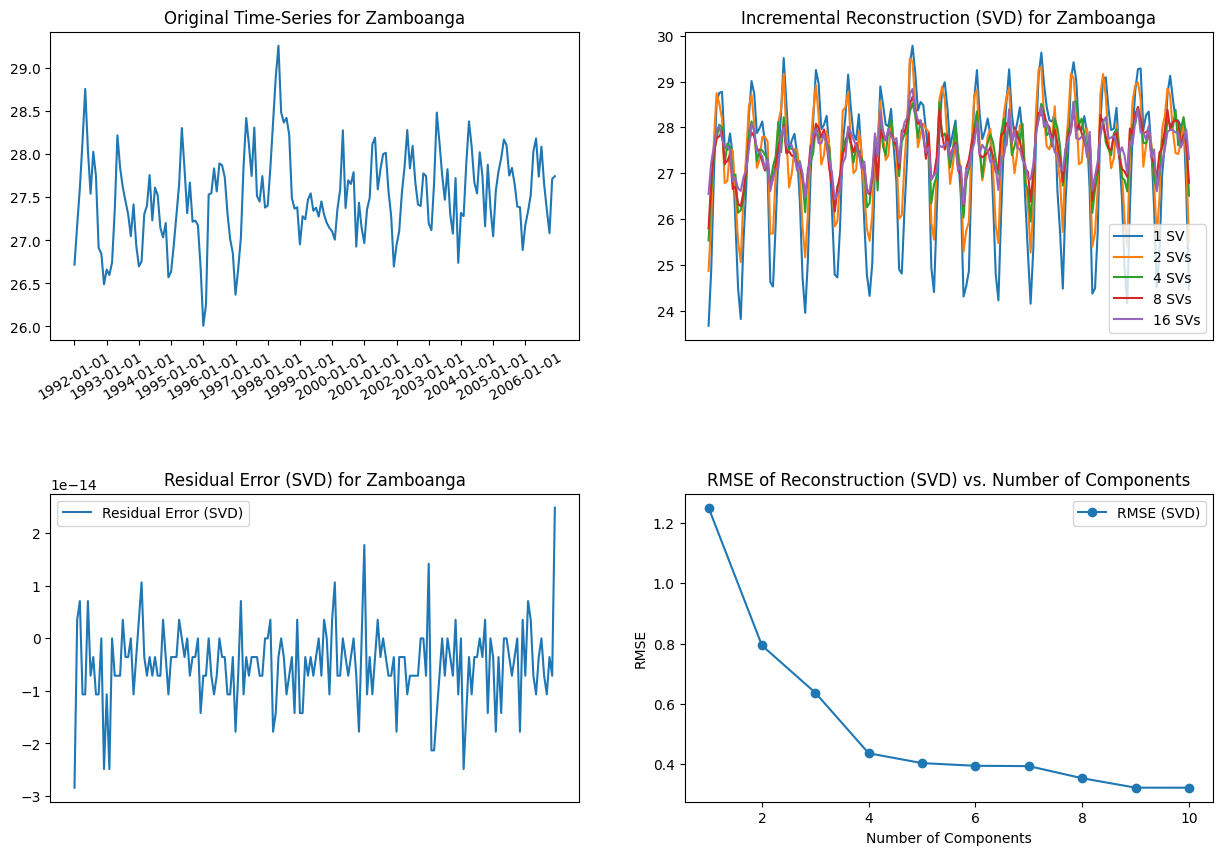

City: Norilsk


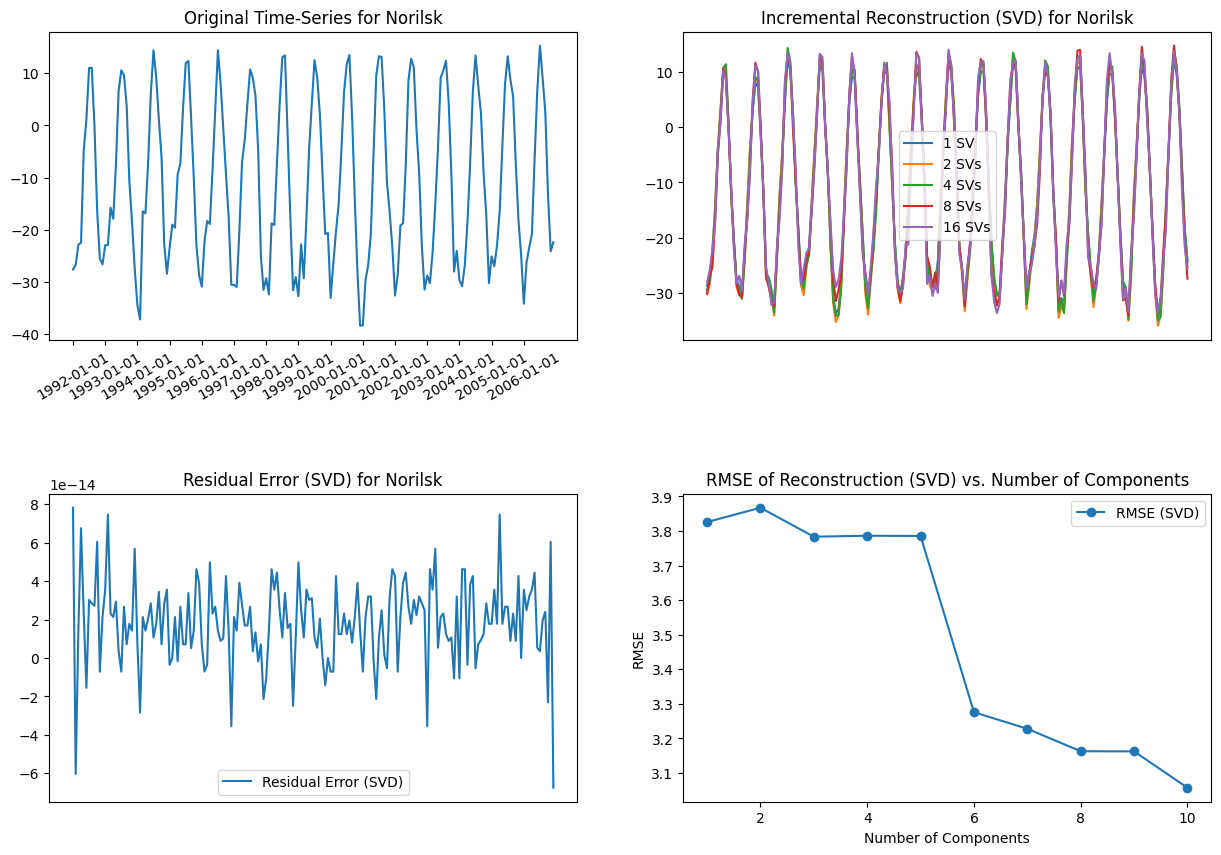

City: Juliaca


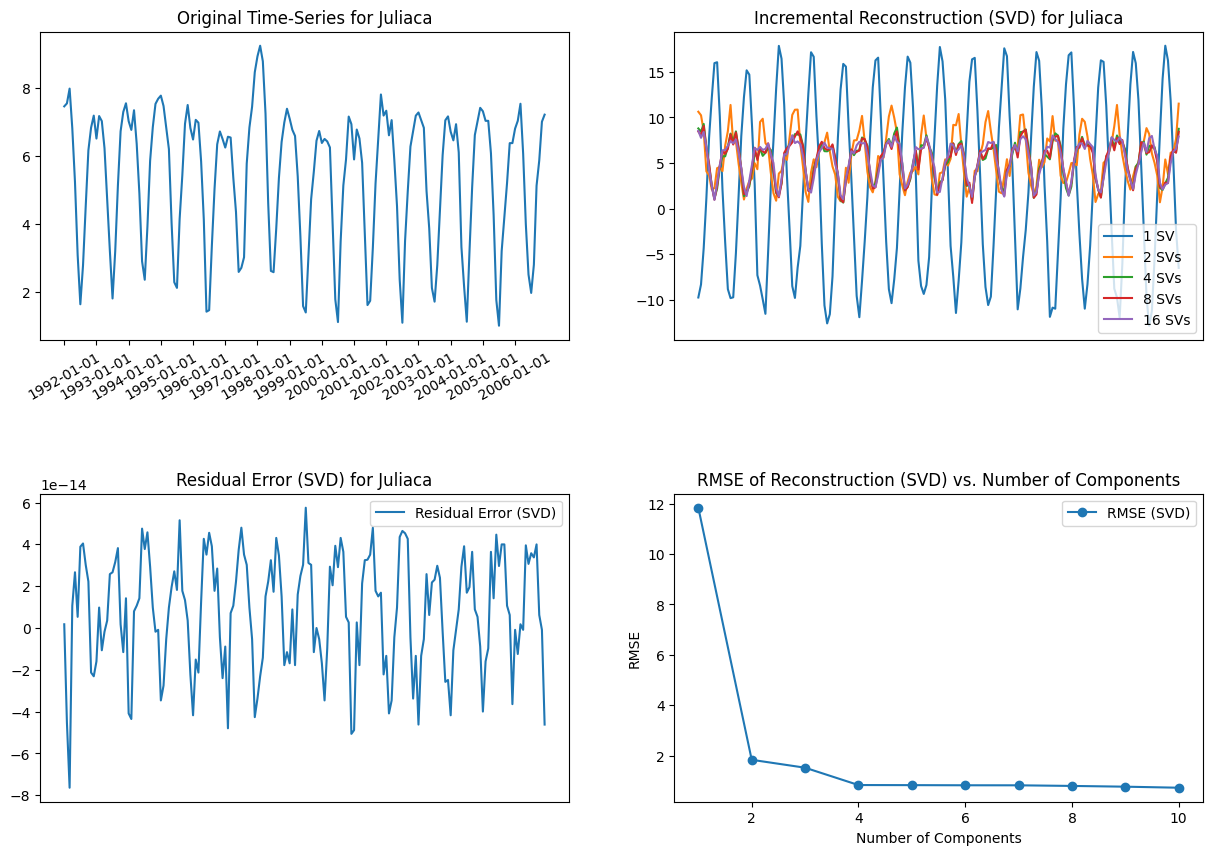

City: Doha


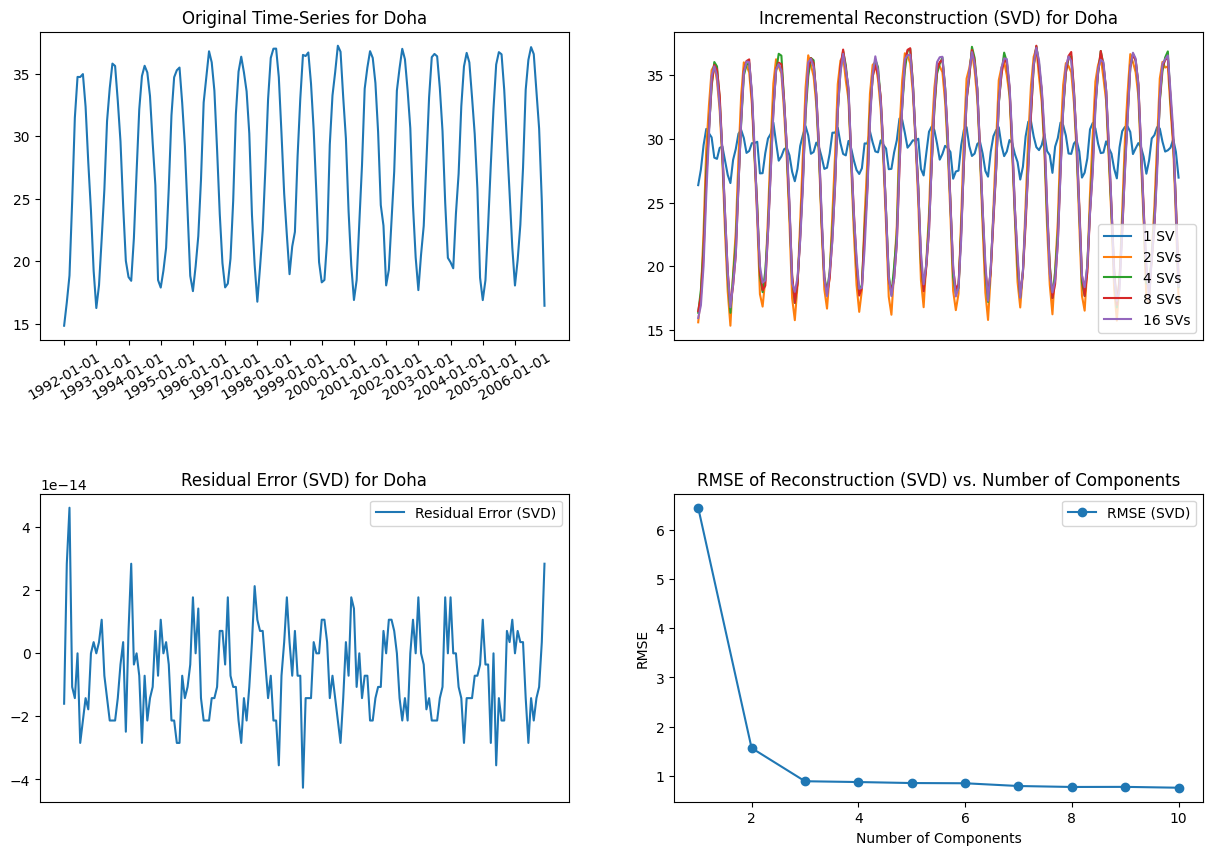

In [17]:
from sklearn.decomposition import PCA

def plot_city_figures_svd(original_df, city_name):

    scaler = StandardScaler()
    df_standardized = scaler.fit_transform(original_df)

    U, s, Vt = np.linalg.svd(df_standardized, full_matrices=False)
    right_sv = Vt.T
    original_time_series = original_df.loc[city_name].values
    original_time_series_standardized = scaler.transform(original_time_series.reshape(1, -1))
    scores_svd = np.dot(original_time_series_standardized, right_sv)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    plt.subplots_adjust(hspace=0.5, wspace=0.2)

    # Plot 1: Original time-series
    dates = original_df.columns
    year_starts = [i for i in range(len(dates)) if dates[i].endswith('-01-01')]
    axes[0, 0].plot(original_df.columns, original_time_series)
    axes[0, 0].set_title(f'Original Time-Series for {city_name}')
    axes[0, 0].set_xticks(ticks=dates[year_starts], labels=dates[year_starts], rotation=30)

    # Plot 2: Incremental reconstruction
    svs_to_include = [1, 2, 4, 8, 16]
    for i in svs_to_include:
        reconstructed_standardized = np.dot(scores_svd[:, :i], right_sv[:, :i].T)
        reconstructed = scaler.inverse_transform(reconstructed_standardized)
        axes[0, 1].plot(original_df.columns, reconstructed.flatten(),
                         label=f'{i} SVs' if i > 1 else f'{i} SV')
    axes[0, 1].set_title(f'Incremental Reconstruction (SVD) for {city_name}')
    axes[0, 1].set_xticks([])
    axes[0, 1].legend()

    # Plot 3: Residual error for the best reconstruction (using all SVD components)
    best_reconstructed_standardized = np.dot(scores_svd, right_sv.T)
    best_reconstructed = scaler.inverse_transform(best_reconstructed_standardized)
    residual_error = original_time_series - best_reconstructed.flatten()
    axes[1, 0].plot(original_df.columns, residual_error, label='Residual Error (SVD)')
    axes[1, 0].set_title(f'Residual Error (SVD) for {city_name}')
    axes[1, 0].set_xticks([])
    axes[1, 0].legend()

    # Plot 4: RMSE as a function of the number of components
    rmse_values_svd = []
    num_components_range = range(1, 11)
    for i in num_components_range:
        reconstructed_standardized = np.dot(scores_svd[:, :i], right_sv[:, :i].T)
        reconstructed = scaler.inverse_transform(reconstructed_standardized)
        # Calculate RMSE
        rmse = np.sqrt(np.mean((original_time_series - reconstructed.flatten())**2))
        rmse_values_svd.append(rmse)
    axes[1, 1].plot(num_components_range, rmse_values_svd, marker='o', label='RMSE (SVD)')
    axes[1, 1].set_title('RMSE of Reconstruction (SVD) vs. Number of Components')
    axes[1, 1].set_xlabel('Number of Components')
    axes[1, 1].set_ylabel('RMSE')
    axes[1, 1].legend()

    plt.show()

cities = ['Yakeshi','Zamboanga', 'Norilsk', 'Juliaca', 'Doha']

for city in cities:
    print(f"City: {city}")
    rmse_values_svd = plot_city_figures_svd(data_raw, city)

Since SVD works on the data matrix, standardization is still required to ensure that all variables contribute equally to the SVD, especially when the variables are on different scales; Covariance matrix computation is not required for SVD since it is not used in the decomposition.

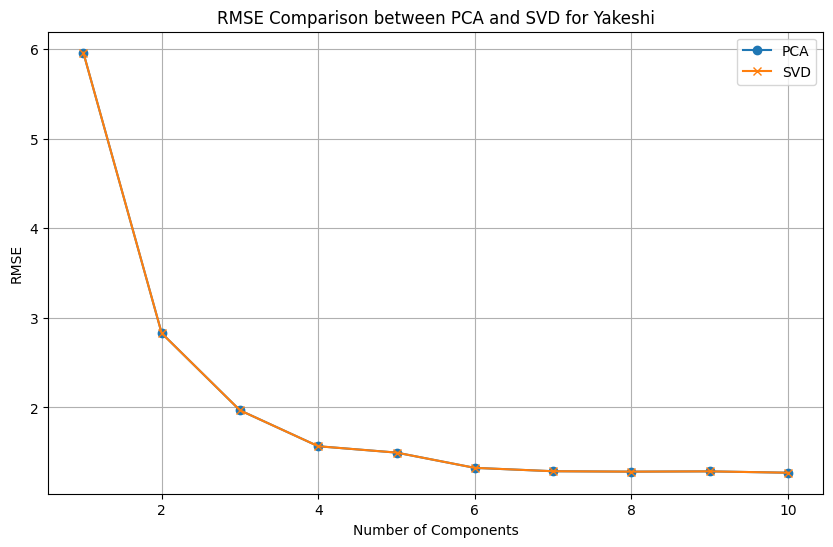

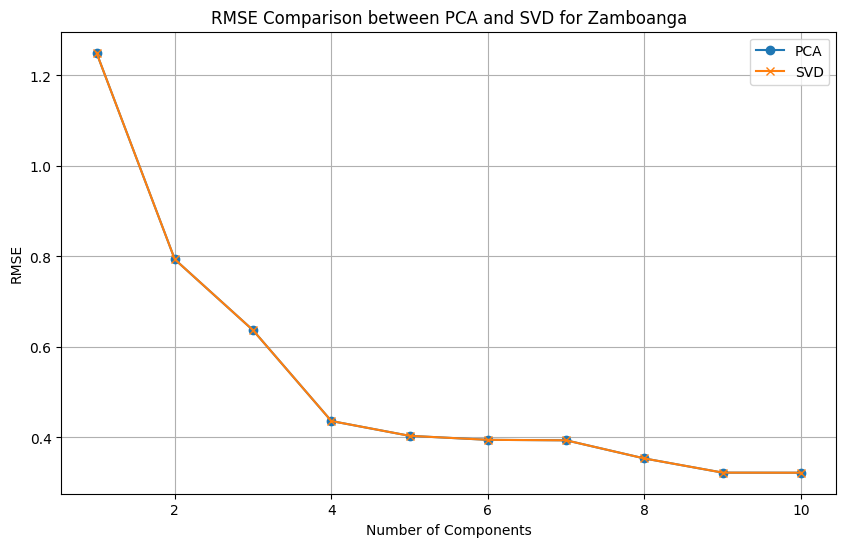

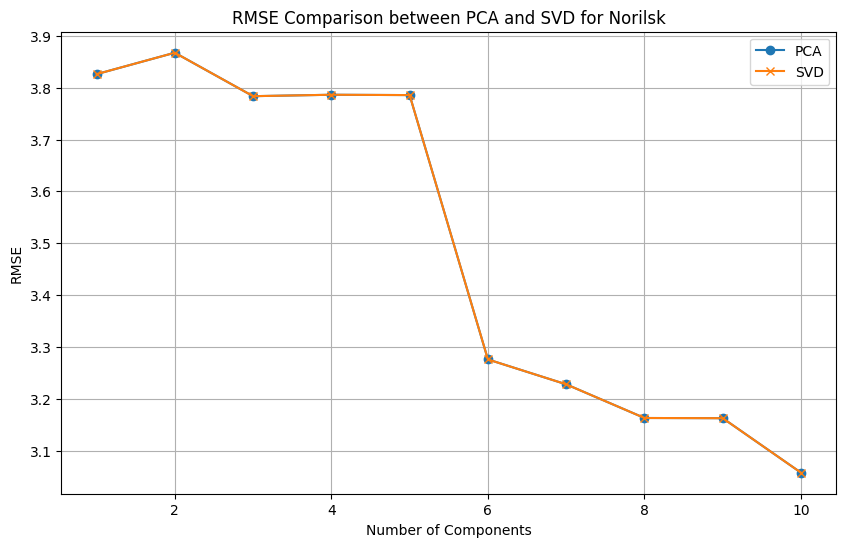

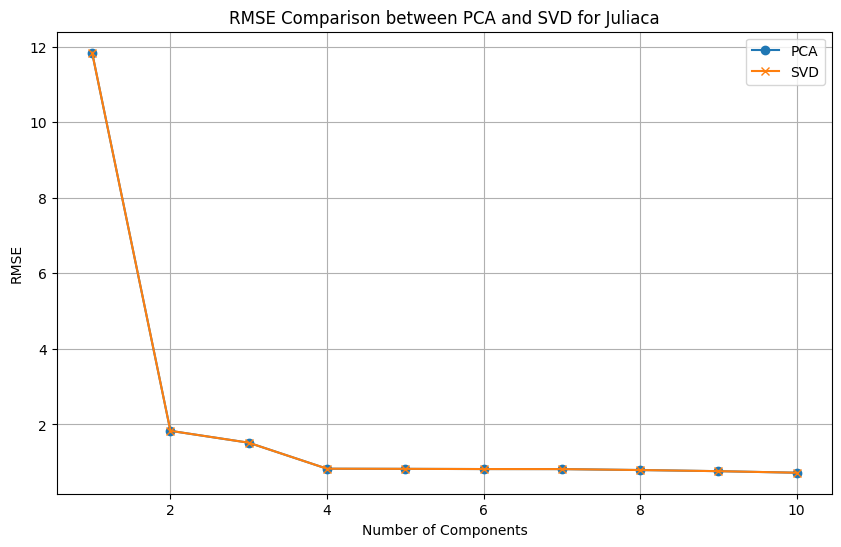

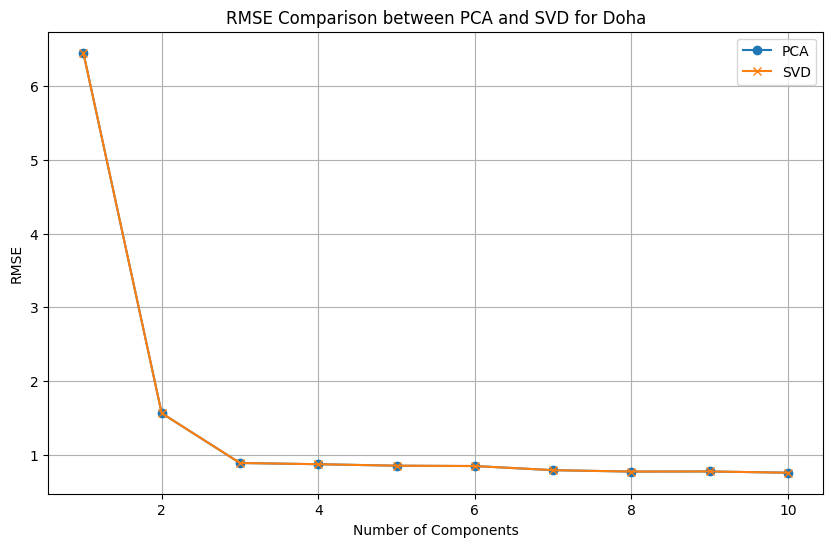

In [ ]:
def calculate_rmse(original, reconstruction):
    return np.sqrt(np.mean((original - reconstruction) ** 2))

def compare_pca_svd_rmse(original_df, city_name):

    scaler = StandardScaler()
    df_standardized = scaler.fit_transform(original_df)

    cov_matrix_standardized = np.cov(df_standardized, rowvar=False)
    eigenvalues_pca, eigenvectors_pca = get_sorted_eigen(cov_matrix_standardized)

    U, s, Vt = np.linalg.svd(df_standardized, full_matrices=False)
    right_sv = Vt.T

    original_time_series = original_df.loc[city_name].values
    original_time_series_standardized = scaler.transform(original_time_series.reshape(1, -1))

    scores_pca = np.dot(original_time_series_standardized, eigenvectors_pca)
    scores_svd = np.dot(original_time_series_standardized, right_sv)

    num_components_range = range(1, 11)
    rmse_pca = []
    rmse_svd = []
    for i in num_components_range:

        reconstructed_pca = scaler.inverse_transform(np.dot(scores_pca[:, :i], eigenvectors_pca[:, :i].T))
        rmse_pca.append(calculate_rmse(original_time_series, reconstructed_pca.flatten()))

        reconstructed_svd = scaler.inverse_transform(np.dot(scores_svd[:, :i], right_sv[:, :i].T))
        rmse_svd.append(calculate_rmse(original_time_series, reconstructed_svd.flatten()))

    plt.figure(figsize=(10, 6))
    plt.plot(num_components_range, rmse_pca, marker='o', label='PCA')
    plt.plot(num_components_range, rmse_svd, marker='x', label='SVD')
    plt.xlabel('Number of Components')
    plt.ylabel('RMSE')
    plt.title(f'RMSE Comparison between PCA and SVD for {city_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    return rmse_pca, rmse_svd

# city_name = 'Yakeshi'
# rmse_pca, rmse_svd = compare_pca_svd_rmse(data_raw, city_name)

cities = ['Yakeshi','Zamboanga', 'Norilsk', 'Juliaca', 'Doha']
for city in cities:
  rmse_pca, rmse_svd = compare_pca_svd_rmse(data_raw, city)


The RMSE comparison between PCA and SVD for all the cities demonstrates that both methods yield identical results, confirming their theoretical equivalence for dimensionality reduction. The RMSE decreases as more components are included, with the most significant drop observed with the first few components. This means that a small number of principal components capture the most of the variance in the data, and adding more components has diminishing returns in reducing reconstruction error.